In [ ]:
import sys
import torch
import warnings
import torchvision
import numpy as np
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms

from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models.inception import inception_v3

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.6/281.6 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.9 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Initialize WandB
wandb.init(project="GAN_Project", name="GAN_Experiment")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Log hyperparameters
config = wandb.config
config.batch_size = 128
config.image_size = 64
config.nc = 3
config.nz = 100
config.ngf = 64
config.ndf = 64
config.num_epochs = 30
config.lrG = 0.0001
config.lrD = 0.0004
config.beta1 = 0.5
config.ngpu = 1

In [ ]:
# Load and preprocess dataset
transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(data, batch_size=config.batch_size, shuffle=True)

# Define classes for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for (images, labels) in dataloader:
    print(images.shape)
    print(labels)
    break

100%|██████████| 170498071/170498071 [00:12<00:00, 13590171.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
torch.Size([128, 3, 64, 64])
tensor([0, 0, 4, 7, 5, 6, 1, 5, 7, 0, 0, 4, 4, 0, 7, 8, 3, 9, 1, 1, 5, 8, 9, 5,
        9, 6, 8, 3, 0, 2, 3, 4, 3, 9, 2, 6, 3, 5, 2, 7, 6, 1, 3, 3, 7, 0, 9, 6,
        9, 9, 5, 6, 6, 5, 1, 6, 7, 3, 4, 7, 9, 3, 8, 4, 8, 7, 4, 0, 1, 4, 3, 6,
        9, 3, 5, 7, 4, 2, 8, 7, 2, 8, 9, 9, 5, 1, 9, 7, 3, 3, 2, 3, 3, 8, 8, 3,
        9, 1, 1, 7, 3, 7, 5, 6, 5, 5, 3, 4, 1, 3, 6, 9, 3, 8, 0, 4, 7, 8, 0, 1,
        8, 5, 3, 1, 9, 8, 2, 7])


In [ ]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(config.nz, config.ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(config.ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(config.ngf*8, config.ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(config.ngf*4, config.ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(config.ngf*2, config.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(config.ngf, config.nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator code

# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(config.nc, config.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(config.ndf, config.ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(config.ndf*2, config.ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(config.ndf*4, config.ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(config.ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Function to initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Initialize generator and discriminator
netG = Generator(config.ngpu).to(device)
netG.apply(weights_init)

netD = Discriminator(config.ngpu).to(device)
netD.apply(weights_init)

# Define loss function and optimizer
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, config.nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=config.lrD, betas=(config.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=config.lrG, betas=(config.beta1, 0.999))

# Lists to keep track of progress
G_losses = []
D_losses = []

print("Starting Training Loop...")
# Training loop
for epoch in range(config.num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # using real data
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # using fake data
        noise = torch.randn(b_size, config.nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # Log losses to WandB
    wandb.log({"Generator Loss": errG.item(), "Discriminator Loss": errD.item()}, step=epoch)

    G_losses.append(errG.item())
    D_losses.append(errD.item())
    print('Epoch: {}/{} G Loss: {:.4f} D Loss: {:.4f}'.format(epoch+1, config.num_epochs, errG.item(), errD.item()))

Starting Training Loop...
Epoch: 1/30 G Loss: 7.5959 D Loss: 0.0840
Epoch: 2/30 G Loss: 7.3487 D Loss: 0.1014
Epoch: 3/30 G Loss: 1.8776 D Loss: 0.6749
Epoch: 4/30 G Loss: 4.2375 D Loss: 0.1706
Epoch: 5/30 G Loss: 3.6177 D Loss: 0.5385
Epoch: 6/30 G Loss: 3.7206 D Loss: 0.2408
Epoch: 7/30 G Loss: 4.3066 D Loss: 0.2529
Epoch: 8/30 G Loss: 5.0857 D Loss: 0.1692
Epoch: 9/30 G Loss: 5.6579 D Loss: 0.2270
Epoch: 10/30 G Loss: 4.9267 D Loss: 0.5419
Epoch: 11/30 G Loss: 1.7499 D Loss: 0.7269
Epoch: 12/30 G Loss: 3.4089 D Loss: 0.2188
Epoch: 13/30 G Loss: 3.6940 D Loss: 0.2435
Epoch: 14/30 G Loss: 3.3989 D Loss: 0.1870
Epoch: 15/30 G Loss: 2.5237 D Loss: 0.3968
Epoch: 16/30 G Loss: 3.5719 D Loss: 0.4775
Epoch: 17/30 G Loss: 2.0363 D Loss: 0.4954
Epoch: 18/30 G Loss: 4.1360 D Loss: 0.0759
Epoch: 19/30 G Loss: 3.9881 D Loss: 0.3730
Epoch: 20/30 G Loss: 3.4146 D Loss: 0.5487
Epoch: 21/30 G Loss: 3.3821 D Loss: 0.4439
Epoch: 22/30 G Loss: 3.7654 D Loss: 0.3039
Epoch: 23/30 G Loss: 2.7735 D Loss: 0

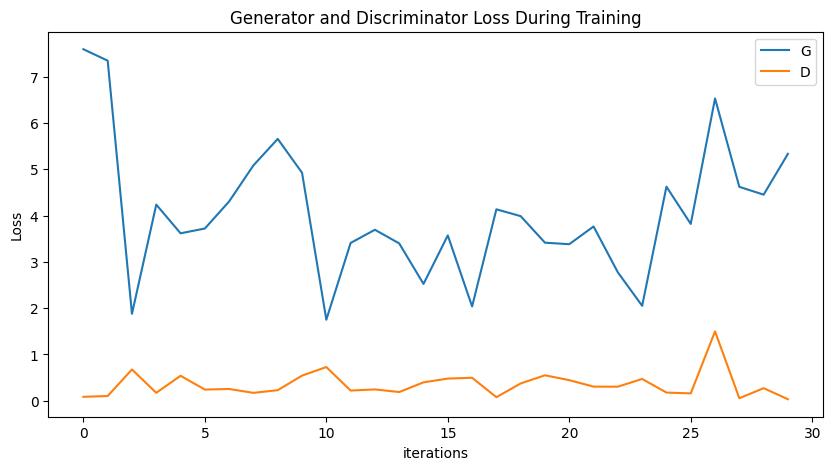

In [ ]:
# Plot of Loss vs Epoch curve
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

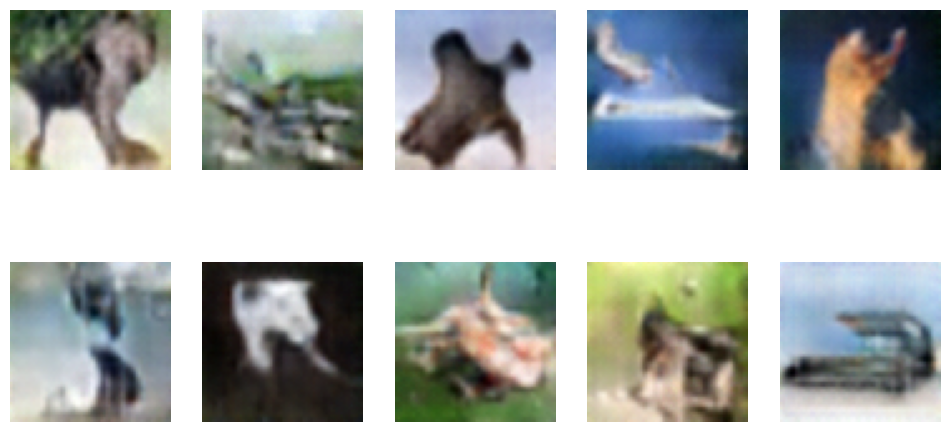

In [ ]:
# Generate images from the learned distribution
netG.eval()

num = 10
images = []
with torch.no_grad():
    for i in range(num):
        noise = torch.randn(1, config.nz, 1, 1, device=device)
        image = netG(noise).detach().cpu()
        images.append(image.squeeze(1))
        vutils.save_image(image, f'image_{i+1}.png', normalize=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num):
    img = plt.imread(f"image_{i+1}.png")
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

In [ ]:
# Inception score of the generated images
def inception_score(imgs, cuda=True, batch_size=10, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0
    assert N == batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)

    # Load Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

print("Calculating Inception Score...")
inception_score, std = inception_score(images, cuda=True, batch_size=10, resize=True, splits=1)
wandb.log({"Inception Score": inception_score})


Calculating Inception Score...


In [ ]:
wandb.log({"Inception Score": inception_score})

In [ ]:
!pip install pytorch-fid scikit-learn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import os

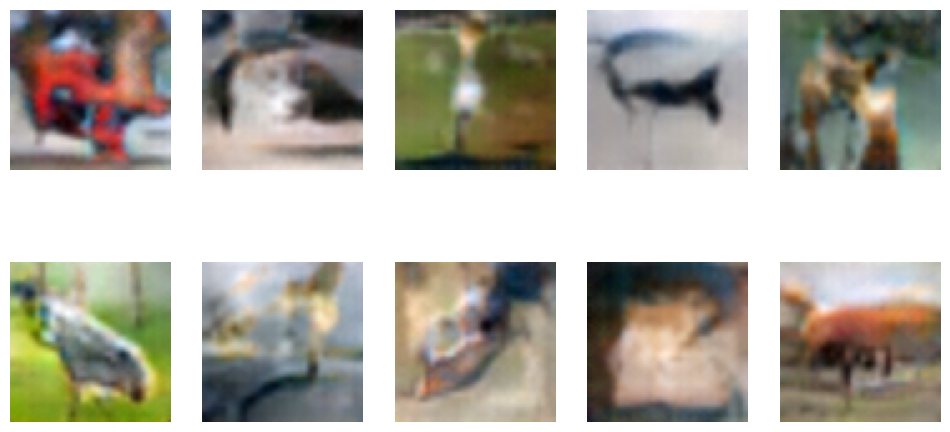

In [ ]:
num = 10
images = []
os.makedirs('fake_images', exist_ok=True)
with torch.no_grad():
    for i in range(num):
        noise = torch.randn(1, nz, 1, 1, device=device)
        image = netG(noise).detach().cpu()
        images.append(image)
        vutils.save_image(image, f'fake_images/image_{i+1}.png', normalize=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num):
    img = plt.imread(f"fake_images/image_{i+1}.png")
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()